## Coding Challenge

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)

from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    BayesianRidge
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor


from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_pinball_loss,
)

from tqdm import tqdm

In [2]:
def compute_metrics(y_true, y_pred):
    metrics = [
        ("r2", r2_score),
        ("mse", mean_squared_error),
        ("rmse", root_mean_squared_error),
        ("mae", mean_absolute_error),
        ("mape", mean_absolute_percentage_error),
    ]

    scores = {name: metric(y_true, y_pred) for name, metric in metrics}
    # scores["pinball(0.05)"] = mean_pinball_loss(y_true, y_pred, alpha=0.05)
    # scores["pinball(0.95)"] = mean_pinball_loss(y_true, y_pred, alpha=0.95)
    return scores

## Read and Sample Dataset

* mit > 678k Einträgen ist der Datensatz zu groß für effektives Training on consumer-grade hardware
* down-sampling des Datensatze auf eine 11% ≙ 80k Einträgen
* starker Skew wegen 0-Preisen wird Modellierung beeinflussen

In [3]:
# reading and sub-sampling
data = pd.read_csv("data/car_ins.csv", sep=";")
sample_size = 80_000
data = data.sort_values("Price", ascending=False).head(sample_size)
data

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,Price
150027,1120377,1.0,0.22,B,9.0,13.0,19.0,100.0,B2,Regular,93.0,R24,4075400.56,1.852455e+07
25274,53865,1.0,0.01,E,6.0,1.0,23.0,80.0,B2,Regular,2456.0,R11,183073.66,1.830737e+07
399662,3083780,1.0,0.02,E,7.0,15.0,21.0,100.0,B2,Diesel,2415.0,R82,182050.00,9.102500e+06
368669,3025890,2.0,0.09,A,7.0,1.0,36.0,50.0,B12,Diesel,38.0,R21,382955.14,4.255057e+06
270621,2141337,1.0,0.32,D,4.0,14.0,18.0,100.0,B2,Regular,863.0,R82,1301172.60,4.066164e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472308,3237372,0.0,0.08,C,6.0,12.0,28.0,64.0,B1,Diesel,190.0,R93,0.00,0.000000e+00
472309,3237373,0.0,0.08,D,6.0,10.0,57.0,50.0,B1,Diesel,1326.0,R93,0.00,0.000000e+00
472310,3237374,0.0,0.08,E,8.0,11.0,28.0,76.0,B3,Regular,3657.0,R82,0.00,0.000000e+00
472311,3237375,0.0,0.08,C,6.0,10.0,34.0,57.0,B2,Diesel,196.0,R24,0.00,0.000000e+00


## Pre-Processing Data

Umsetzung
* Aufbereitung der Variablen abhängig vom Datentype
* Numerische Daten
    * können unterschiedliche Skalen haben
    * vereintlicht durch Standardisiering: $ X := \frac{X - \mu}{\sigma}$
* Kategorische Daten
    * können verschieden viele Ausprägungen haben
    * umwandeln in Dummies mit OneHot Encoding (= eine binäre Variable pro Ausprägung)
* Binäre Daten
    * binäre Kategorien werden in einer Variable mit 0|1 ersetzt


Alternativen
* `Region` | `Area` könnten mir geograpischen Koordinaten in numerische Daten umgewandelt werden
* `VehBrand` können mit domänenspezifischen Scoring in numerische Daten umgewandelt werden
* Zielvariable `Price` sollte wegen starkem Skew normal transformiert (Log) werden

In [4]:
y = data["Price"]
X = data[["Area", "VehPower", "VehAge", "DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"]]

numeric_features = ["VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]
categorical_features = ["Area", "VehBrand", "Region"]
binary_features = ["VehGas"]



preprocess = ColumnTransformer(
    [
        ("numeric", StandardScaler(), numeric_features),
        ("categorical", OneHotEncoder(), categorical_features),
        ("binary", OneHotEncoder(drop="if_binary"), binary_features),
    ],
    remainder="passthrough",
    verbose_feature_names_out=True
)

test_size = (1/4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=2024)

X_train = preprocess.fit_transform(X_train)
X_test = preprocess.transform(X_test)
# y_train = np.log1p(y_train)
# y_test = np.log1p(y_test)

## Model Training

* Vorauswahl verschiedener Regression Modelle um verschiedene Modellierungsarten zu testen
* daher Auswahl unterschiedlicher Arten: Linear, Tree, Ensemble, Neural, etc.
* Berechnung div. Regression Metriken zum relativen Vergleich der Modelle untereinander
* falls es Benchmark-Modell / analytischen Modell gibt, sollten dagegen verglichen werden
* Nutzung von Dummy Modell als Diagnosemittel (alternativ zu Benchmark-Modell)
    * andere Modelle sollten nicht schlechter sein als Dummy Modell

In [5]:
random_state = 42
n_jobs = -1
max_iter=10_000
quantile = 0.5
intercept = False

models = [
    ("Linear Regression", LinearRegression(fit_intercept=intercept)),
    ("Lasso Regression", Lasso(alpha=1.0, fit_intercept=intercept, max_iter=max_iter, random_state=random_state)),
    ("Decision Tree", DecisionTreeRegressor(max_depth=3, random_state=random_state)),
    ("Bayesian Ridge", BayesianRidge(max_iter=max_iter, fit_intercept=intercept)),
    ("Dummy Regression (mean)", DummyRegressor(strategy="mean")),
    ("K-Nearest Neighbors", KNeighborsRegressor(n_neighbors=100, n_jobs=n_jobs)),
    ("Random Forest", RandomForestRegressor(random_state=random_state, n_jobs=n_jobs)),
    ("Gradient Forest", GradientBoostingRegressor(random_state=random_state)),
    ("Neural Network", MLPRegressor((16, 16, 16, 8, ), random_state=random_state, max_iter=max_iter)),
]

trained_model = []
test_scores = {}

train_predictions = []
test_predictions = []



for name, model in tqdm(models, miniters=len(models), desc="Training & Evaluation"):
    model.fit(X_train.toarray(), y_train)
    y_pred_test = model.predict(X_test.toarray())
    y_pred_train = model.predict(X_train.toarray())

    train_predictions.append(y_pred_train)
    test_predictions.append(y_pred_test)

    test_scores[name] = compute_metrics(y_pred_test, y_test)
    trained_model.append((name, model))

Training & Evaluation: 100%|██████████| 9/9 [03:49<00:00, 25.47s/it]


## Evaluation

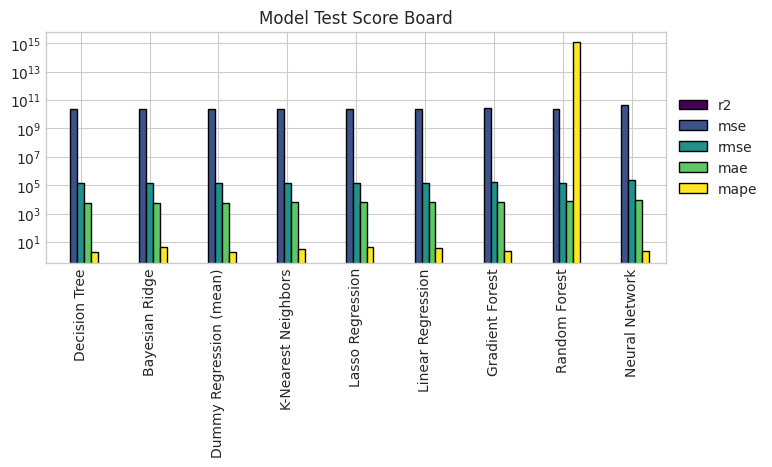

In [20]:
test_scores_df = round(pd.DataFrame(test_scores),2)
test_scores_df = test_scores_df.T.sort_values("mae", ascending=True)

test_scores_df.plot(
    kind="bar",
    cmap="viridis",
    edgecolor="k",
    title="Model Test Score Board",
    figsize=(8, 3),
)
plt.axhline(color="k", lw=0.5)
plt.yscale("log")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5));

In [7]:
test_scores_df

,r2,mse,rmse,mae,mape
Decision Tree,-1.667930e+03,2.187326e+10,147896.13,5545.40,2.060000e+00
Bayesian Ridge,-4.149860e+03,2.185575e+10,147836.89,5550.03,4.510000e+00
Dummy Regression (mean),-1.057304e+35,2.186454e+10,147866.61,5791.15,1.900000e+00
K-Nearest Neighbors,-2.278600e+02,2.195650e+10,148177.27,5972.82,3.360000e+00
Lasso Regression,-2.663810e+03,2.185687e+10,147840.69,6035.40,4.200000e+00
Linear Regression,-2.636560e+03,2.185698e+10,147841.05,6043.90,4.000000e+00
Gradient Forest,-3.160000e+00,2.874281e+10,169537.04,6794.50,2.260000e+00
Random Forest,-1.670000e+01,2.314826e+10,152145.52,7078.40,1.178768e+15
Neural Network,-8.600000e-01,4.722527e+10,217313.76,8627.27,2.270000e+00


Quantitativer Verlgeich  
* alle Metriken sehr ähnlich im Raking auf Score Board (visuell und tabellarisch)
* keine Art vom Regression Typ sticht hervor als besonders gut oder schlecht
* beste Modelle nach Ranking (sortieren nach Mean Absolute Error):
    * Decicion Tree
    * Bayes Regression
* Dummy Modell an dritter Stelle weißt auf Probleme mit Modellierung hin
* weitere Prognose nötig

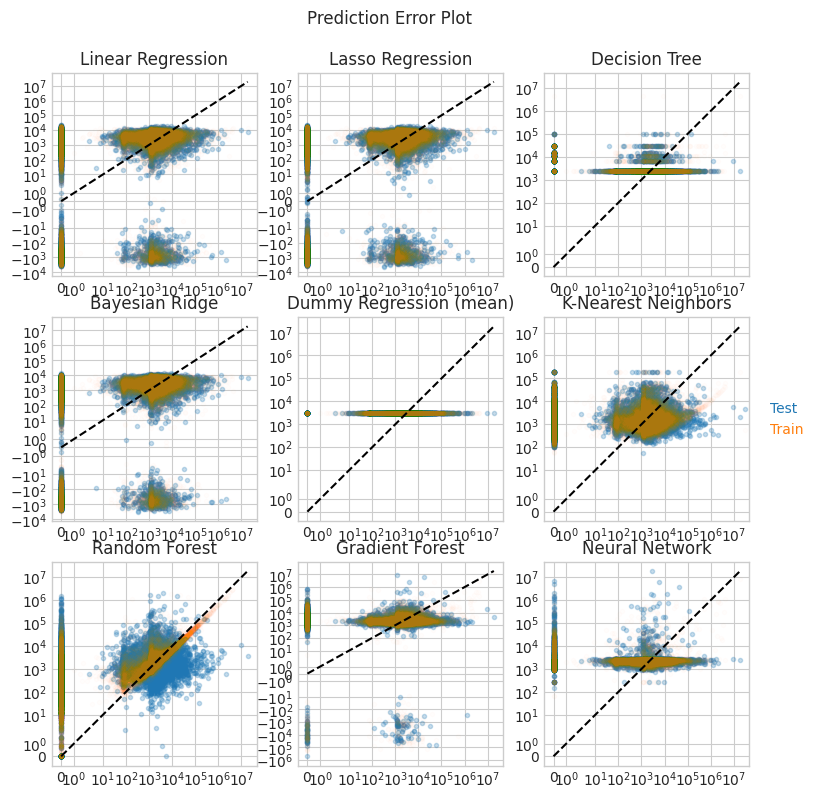

In [22]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9))
fig.suptitle("Prediction Error Plot", y=0.95)
ax = ax.flatten()

y_max = max(y_train)
names = [model[0] for model in trained_model]

i = 0
for name, pred_test, pred_train in zip(names, test_predictions, train_predictions):

    ax[i].scatter(y_test, pred_test, alpha=0.25, marker=".", label="Test")
    ax[i].scatter(y_train, pred_train, alpha=0.01, marker=".", label="Train") #, color="tab:green")
    
    ax[i].plot([0, y_max], [0, y_max], ls="--", color="k")
    ax[i].set(
            title=name,
            xscale="symlog",
            yscale="symlog",
        )
    i+=1

ax[5].legend(loc="center left", bbox_to_anchor=(0.85, 0.5), labelcolor=["tab:blue", "tab:orange"]);

Predition Error Plot
* effektives, visuelles Prognose-Tool als alternative zu quantitativer Evaluation
* Interpretation
    * wenn Punkt über der Diagonale liegt, dann vom Modell überschätzt
    * wenn Punkt unter der Diagonale liegt, dann vom Modell unterschätzt
    * je näher alle Punkte an der Diagonale, desto besser das Modell

Bewertung
* allgemeine Beobachtungen:
    * vertikale Verteilung/Streuung bei 0-Preisen auf linker Seite 
        * starker Skew beeinflusst Modellierungs-Performance negativ
    * horizontale Verteilungen/Streuung
        * viele Einträge/Versicherungsnehmer mit sehr ähnlichen Features aber stark unterschiedlichen Preisen
        * nicht gut differenzierbar für Modelle
        * Bebehung: fehlende Daten hinzufügen, weitere Aufbereitung  
* Lineare, Lasso, Bayes und Gradient Forest haben negative Preise
    * fachlich falsch und unzulässig
* bestes Modell für weitere Fine-Tuning Random Forest
    * abgesehen von Null-Preis Ausreißern, liegen Trainingsdaten nah an Diagonale
    * Testdaten relativ zufällig gleichmäßig verteilt um Diagonale

## Model Insights

In [11]:
def plot_lin_reg_coeff(features, coefficients, title):

    plt.title(f"{title} Coefficients Plot")
    plt.bar(features, coefficients, edgecolor="k")
    plt.axhline(color="k", lw=0.5)
    for feat, coeff in zip (features, coefficients):
        sign = np.sign(coeff)
        va = "bottom" if sign == 1.0 else "top"
        plt.annotate(f"{coeff/1_000:.1f}K", (feat, coeff), ha="center", va=va, fontsize=6, rotation=90)
    plt.xticks(rotation=90)

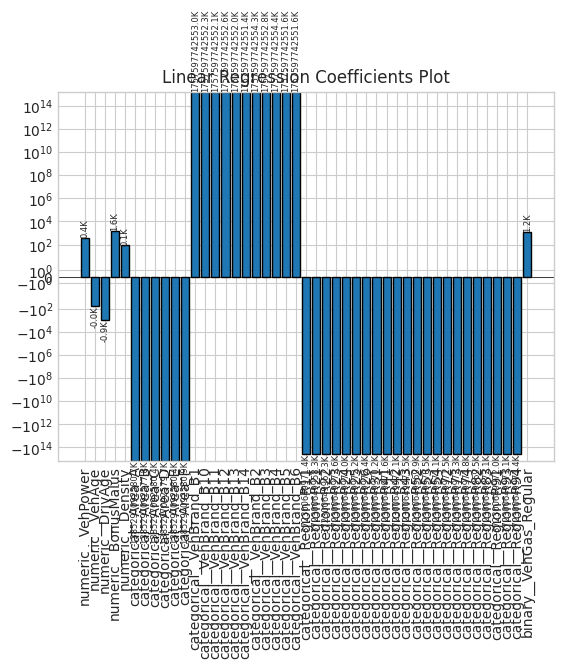

In [12]:
# linear -int
proc_features = preprocess.get_feature_names_out()
plot_lin_reg_coeff(proc_features, models[0][1].coef_, models[0][0])
plt.yscale("symlog")

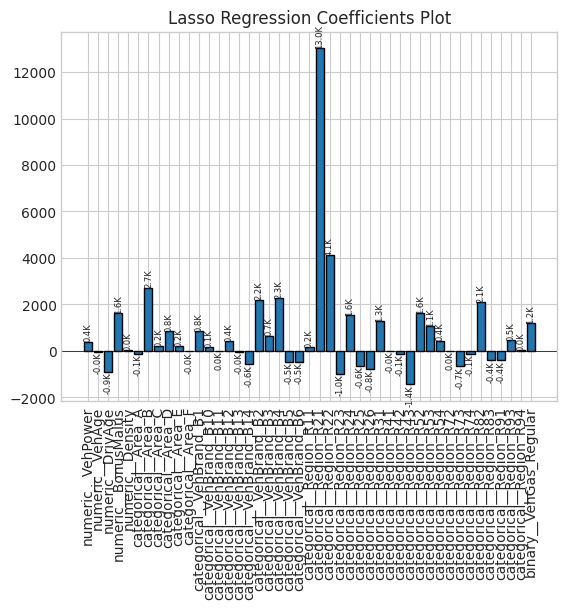

In [13]:
# lasso reg
plot_lin_reg_coeff(proc_features, models[1][1].coef_, models[1][0])

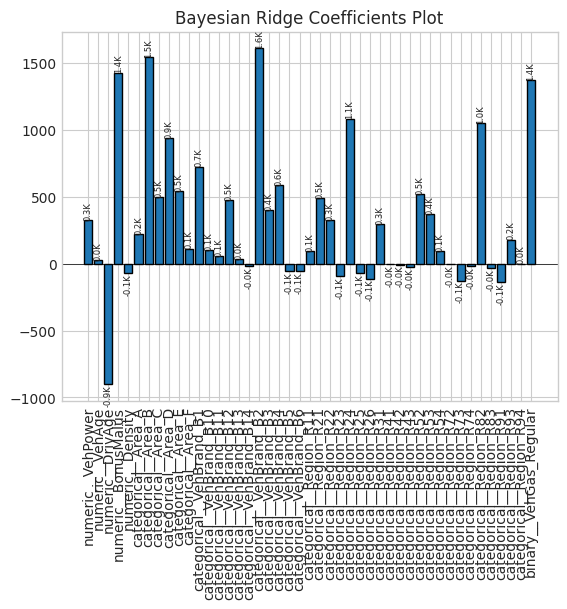

In [14]:
# bayes reg
plot_lin_reg_coeff(proc_features, models[3][1].coef_, models[3][0])

In [41]:
def get_top_features(features, coefficients, top_k=5):
    feature_rank = dict(zip(features, coefficients ))
    feature_rank = sorted(feature_rank.items(), key=lambda pair: pair[1], reverse=True)
    if top_k > 0:
        return feature_rank[:top_k]
    elif top_k < 0:
        return feature_rank[top_k:]

In [48]:
# bayes reg positive features
get_top_features(proc_features, models[3][1].coef_, 5)

[('categorical__VehBrand_B2', np.float64(1607.932157895672)),
 ('categorical__Area_B', np.float64(1543.8860021234557)),
 ('numeric__BonusMalus', np.float64(1426.5664305734113)),
 ('binary__VehGas_Regular', np.float64(1368.6532191653928)),
 ('categorical__Region_R24', np.float64(1083.6180331658222))]

In [46]:
# bayes reg negative features
get_top_features(proc_features, models[3][1].coef_, -2)

[('categorical__Region_R91', np.float64(-140.54854044574915)),
 ('numeric__DrivAge', np.float64(-901.7589767486211))]

Bayesian Regression Top 5 Features
* `VehBrand_B2`: Automarke B2 hat eine starken, positive Einfluss
* `Area_B`: Area 2 hat eine starken, positive Einfluss
* `Region_R91`: Region R91 hat eine starken, negativen Einfluss
* `DrivAge`: Alter hat eine starken, negativen Einfluss

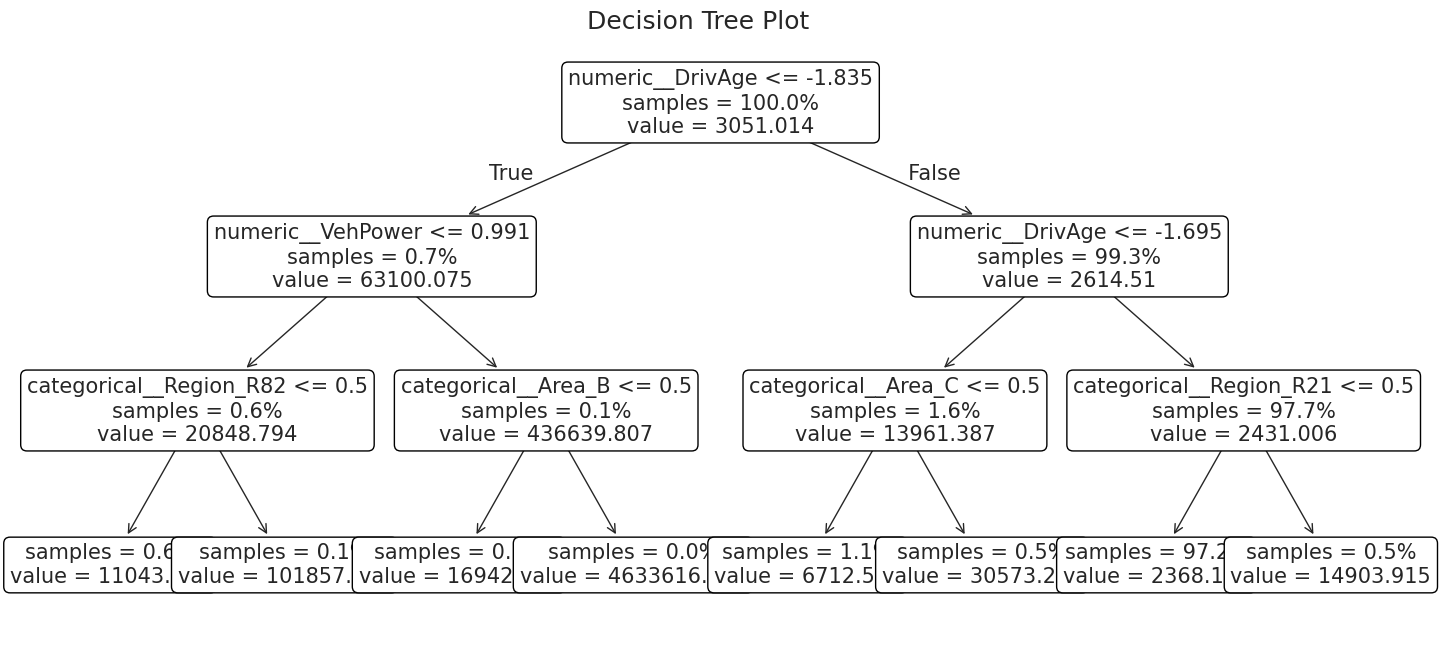

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
fig.suptitle("Decision Tree Plot", fontsize=18, y=0.9)

plot_tree(models[2][1], feature_names=proc_features, impurity=False, rounded=True, fontsize=15, proportion=True, ax=ax);

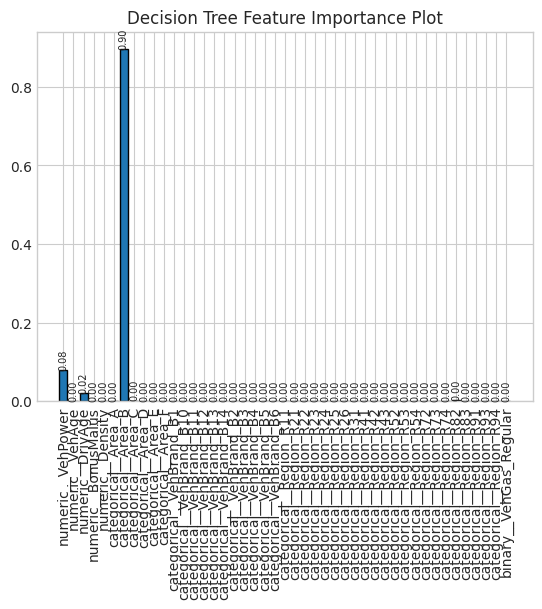

In [16]:
def plot_feature_importance(features, importances, title):
    plt.title(f"{title} Feature Importance Plot")
    plt.bar(features, importances, edgecolor="k")
    plt.axhline(color="k", lw=0.5)
    for feat, imp in zip (features, importances):
        plt.annotate(f"{imp:.2f}", (feat, imp), ha="center", va="bottom", fontsize=7, rotation=90)
    plt.xticks(rotation=90)

plot_feature_importance(proc_features, models[2][1].feature_importances_, models[2][0])


In [54]:
get_top_features(proc_features, models[2][1].feature_importances_, 3)

[('categorical__Area_B', np.float64(0.8959623571030477)),
 ('numeric__VehPower', np.float64(0.0790002498447147)),
 ('numeric__DrivAge', np.float64(0.019614476144981706))]

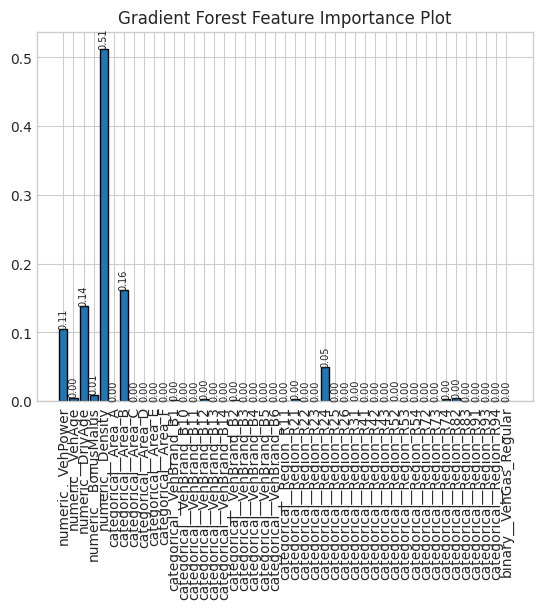

In [17]:
plot_feature_importance(proc_features, models[7][1].feature_importances_, models[7][0])

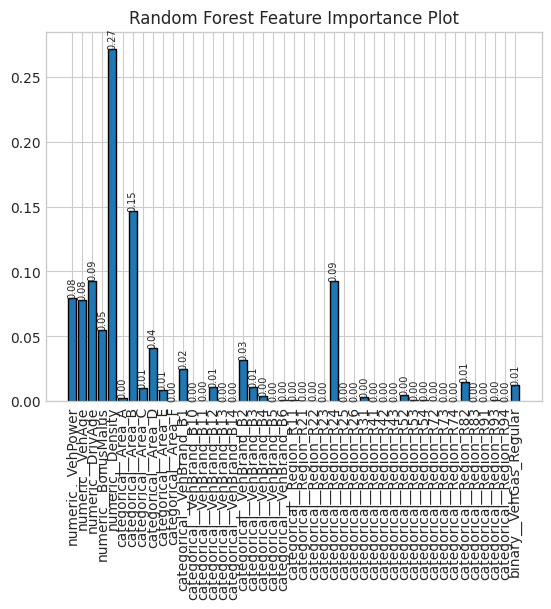

In [18]:
plot_feature_importance(proc_features, models[6][1].feature_importances_, models[6][0])

In [36]:
get_top_features(proc_features, models[6][1].feature_importances_, 5)

[('numeric__Density', np.float64(0.27132115494381814)),
 ('categorical__Area_B', np.float64(0.14666177641110137)),
 ('numeric__DrivAge', np.float64(0.09297502068702351)),
 ('categorical__Region_R24', np.float64(0.0925800457997709)),
 ('numeric__VehPower', np.float64(0.07952211353868029))]

Random Forest Top 5 Feature
* `Density` -> Bevölkerungsdichte hat starken Einfluss
* `Area_B` -> Wohnen in Area B hat starken Einfluss
* `DrivAge` -> Alter hat starken Einfluss
* `Region_24` -> Wohnen in Region 24 hat starken Einfluss